In [1]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn import tree
from xgboost import plot_tree
import pandas as pd
import numpy as np
import os
import wget
from pathlib import Path
import shutil
import gzip
import joblib
from xgboost import XGBClassifier
from mlciic import functions
from mlciic import metrics as met
from matplotlib import pyplot as plt

random_state=42
np.random.seed(random_state)

In [5]:
df_train = pd.read_csv('../../data/EdgeIIot_train_dummies.csv', low_memory=False)
df_test = pd.read_csv('../../data/EdgeIIot_test_dummies.csv', low_memory=False)

functions.display_information_dataframe(df_train,showCategoricals = True, showDetailsOnCategorical = True, showFullDetails = True)

print(df_train["Attack_type"].value_counts())

df_train.drop(["Attack_label"], axis=1, inplace=True)
df_test.drop(["Attack_label"], axis=1, inplace=True)

features = [ col for col in df_train.columns if col not in ["Attack_label"]+["Attack_type"]] 


#for the SMOTE part, so it can fit in 16gb of RAM
df_before = df_train
df_attacks = df_train[df_train["Attack_type"] != "Normal"]

df_normal = df_train[df_train["Attack_type"] == "Normal"]
df_normal = shuffle(df_normal)
df_normal = df_normal[:250000]
df_train = pd.concat([df_attacks,df_normal])
df_train = shuffle(df_train)

---
Lines: 1527737
Columns: 97 
Missing value or NaN: 0
---
Categorical columns: 
['Attack_type']

--- Details for categorical columns ---
Attack_type: 
['Normal' 'DDoS_UDP' 'Password' 'DDoS_TCP' 'Backdoor' 'DDoS_ICMP'
 'Port_Scanning' 'Vulnerability_scanner' 'SQL_injection' 'DDoS_HTTP'
 'Uploading' 'XSS' 'Ransomware' 'MITM' 'Fingerprinting']



,Data Type,Column Name,Unique Values
0,float64,arp.opcode,"[0.0, 2.0, 1.0]"
1,float64,arp.hw.size,"[0.0, 6.0]"
2,float64,icmp.checksum,"[0.0, 25274.0, 56236.0, 32598.0, 21835.0, 1449..."
3,float64,icmp.seq_le,"[0.0, 57101.0, 15950.0, 19413.0, 41521.0, 3247..."
4,float64,icmp.unused,[0.0]
5,float64,http.content_length,"[0.0, 277.0, 57.0, 1415.0, 36.0, 1.0, 1465.0, ..."
6,float64,http.response,"[0.0, 1.0]"
7,float64,http.tls_port,[0.0]
8,float64,tcp.ack,"[6.0, 0.0, 91101.0, 3531.0, 5.0, 303.0, 59.0, ..."
9,float64,tcp.ack_raw,"[2774423095.0, 0.0, 2371715782.0, 2371628212.0..."


Normal                   1091222
DDoS_UDP                   96966
DDoS_ICMP                  54438
SQL_injection              40755
Vulnerability_scanner      40086
DDoS_TCP                   40053
Password                   39825
DDoS_HTTP                  38916
Uploading                  29534
Backdoor                   19244
Port_Scanning              15915
XSS                        12031
Ransomware                  7763
Fingerprinting               707
MITM                         282
Name: Attack_type, dtype: int64


In [9]:
pd.options.display.max_rows = 4000
print(df_train["Attack_type"].value_counts())

df_train.drop_duplicates(subset=None, keep="first", inplace=True)

Normal                   250000
DDoS_UDP                  96966
DDoS_ICMP                 54438
SQL_injection             40755
Vulnerability_scanner     40086
DDoS_TCP                  40053
Password                  39825
DDoS_HTTP                 38916
Uploading                 29534
Backdoor                  19244
Port_Scanning             15915
XSS                       12031
Ransomware                 7763
Fingerprinting              707
MITM                        282
Name: Attack_type, dtype: int64


In [10]:
print("after duplicates")
print(df_train["Attack_type"].value_counts())

after duplicates
Normal                   250000
DDoS_UDP                  96966
DDoS_ICMP                 54438
SQL_injection             40755
Vulnerability_scanner     40086
DDoS_TCP                  40053
Password                  39825
DDoS_HTTP                 38916
Uploading                 29534
Backdoor                  19244
Port_Scanning             15915
XSS                       12031
Ransomware                 7763
Fingerprinting              707
MITM                        282
Name: Attack_type, dtype: int64


In [23]:
import umap

df_small = pd.read_csv('../../data/DNN-EdgeIIoT-dataset_SMALL.csv', low_memory=False)

drop_columns = ["frame.time", "ip.src_host", "ip.dst_host", "arp.src.proto_ipv4","arp.dst.proto_ipv4", 
         "http.file_data","http.request.full_uri","icmp.transmit_timestamp",
         "http.request.uri.query", "tcp.options","tcp.payload","tcp.srcport",
         "tcp.dstport", "udp.port", "mqtt.msg"]

df_small.drop(drop_columns, axis=1, inplace=True)

categorical_columns = []
for col in df_small.columns[df_small.dtypes == object]:
    if col != "Attack_type":
        categorical_columns.append(col)

featuresFromStart = [ col for col in df_small.columns if col not in ["Attack_label"]+["Attack_type"]]

colunas_one_hot = {}
for coluna in categorical_columns:
    codes, uniques = pd.factorize(df_small[coluna].unique())
    colunas_one_hot[coluna] = {"uniques": uniques, "codes":codes}
    df_small[coluna] = df_small[coluna].replace(colunas_one_hot[coluna]["uniques"], colunas_one_hot[coluna]["codes"])
df_small = pd.get_dummies(data=df_small, columns=categorical_columns)


features = [ col for col in df_small.columns if col not in ["Attack_label"]+["Attack_type"]] 
X_small = df_small[features].values
y_small = df_small["Attack_type"].values



reducer = umap.UMAP()

X_small = StandardScaler().fit_transform(X_small)

le = LabelEncoder()
le.fit(df_small["Attack_type"].values)

y_small = le.transform(y_small)

In [24]:
print(X_small.shape)
print(len(X_small))
print(len(X_small[0]))
print(y_small.shape)

embedding = reducer.fit_transform(X_small, y_small)
print(embedding.shape)

(14400, 67)
14400
67
(14400,)


/Users/melicias/.local/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


(14400, 2)


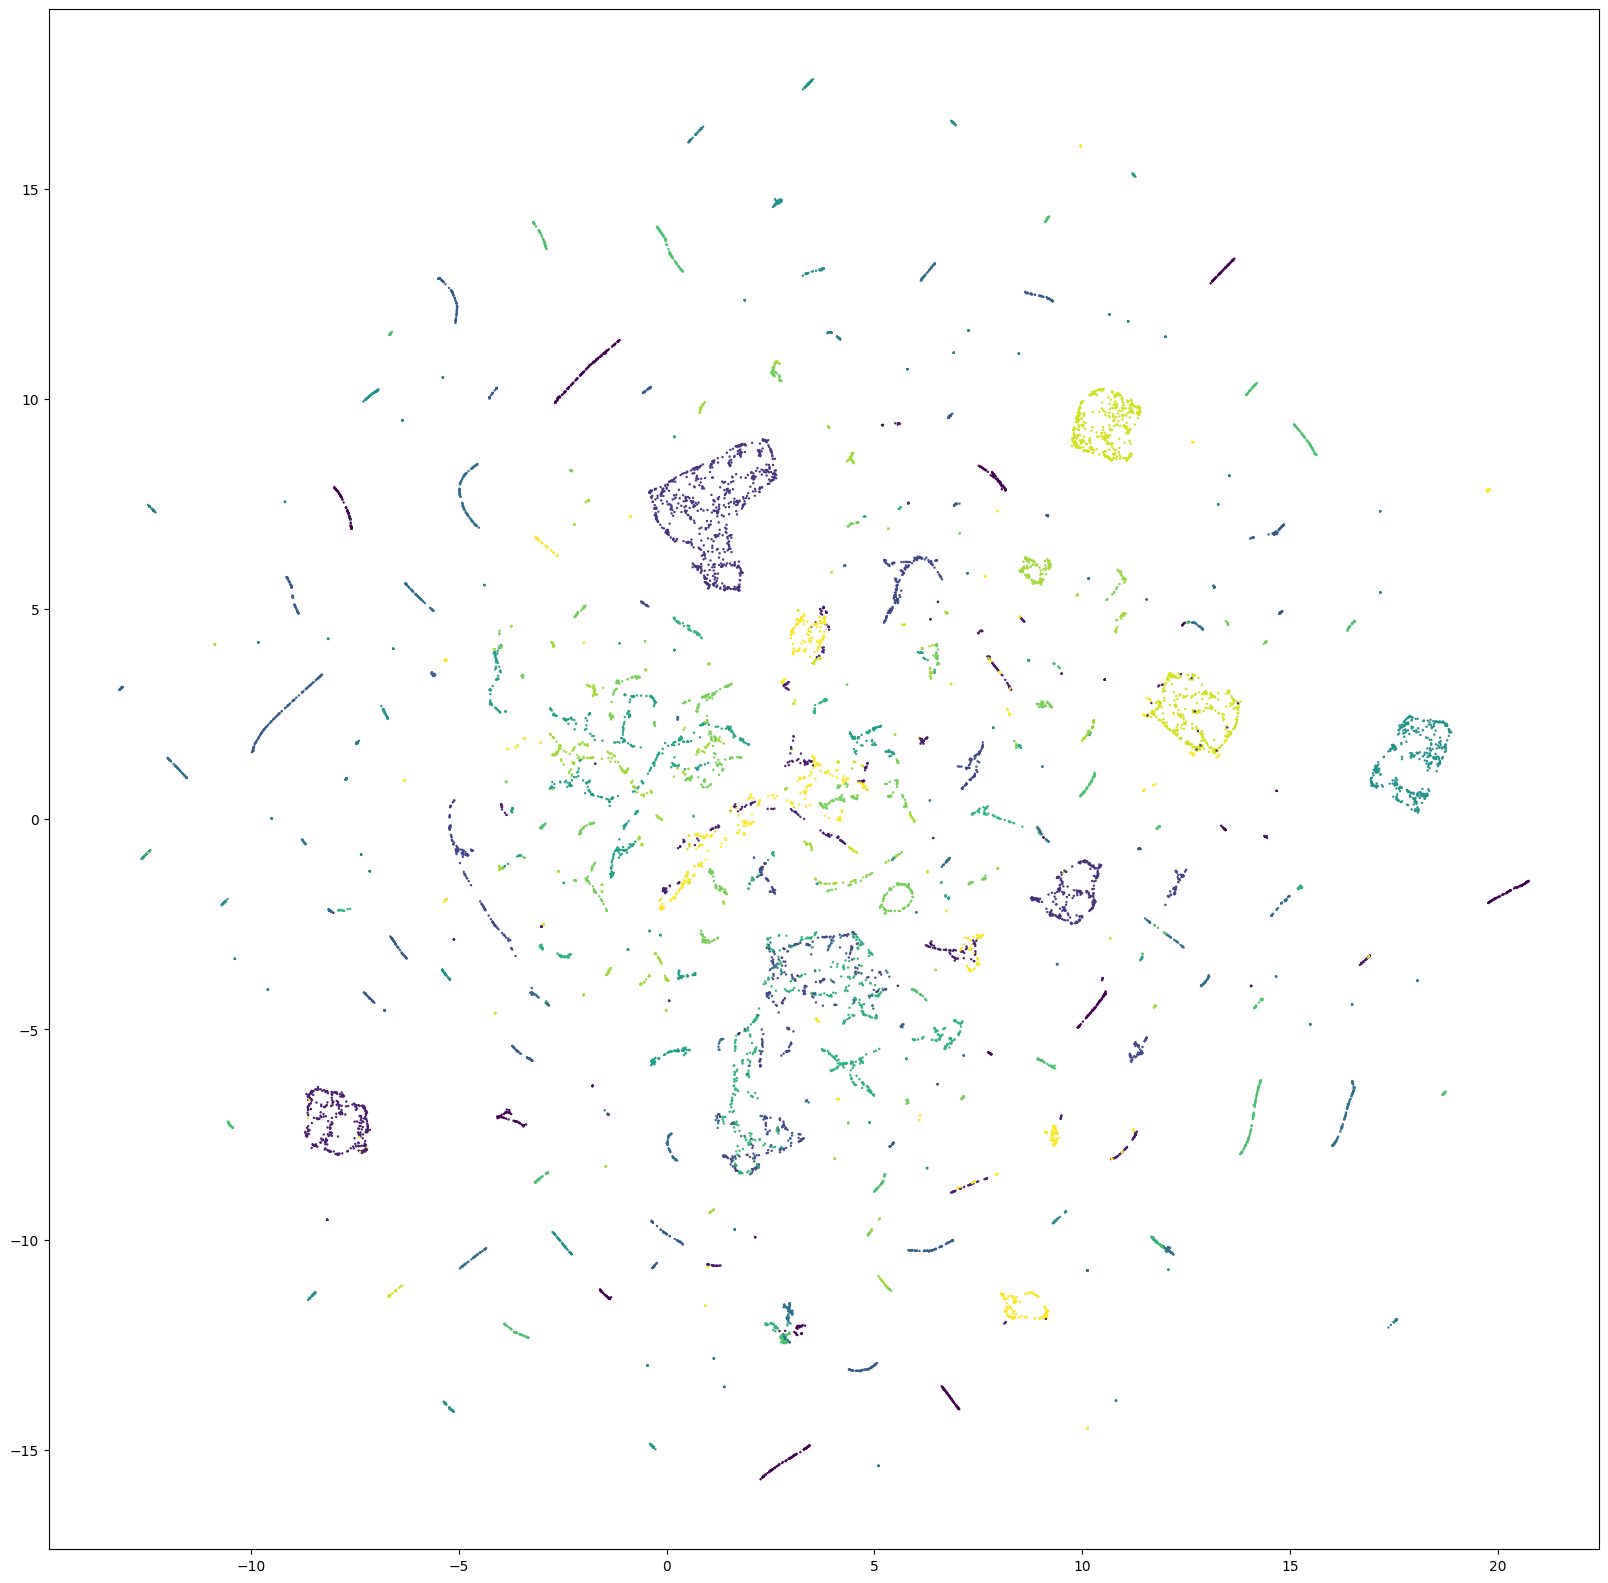

In [28]:
plt.rcParams["figure.figsize"] = (20,20)
plt.scatter(embedding[:, 0], embedding[:, 1], c=y_small, s=0.5)

plt.savefig('te.png', dpi=300, bbox_inches='tight')

In [29]:
sm = SMOTE(random_state=random_state,n_jobs=-1)
X_small_smote, y_small_smote = sm.fit_resample(X_small, y_small)

print(X_small_smote.shape)
print(len(X_small_smote))
print(len(X_small_smote[0]))
print(y_small_smote.shape)

embedding_smote = reducer.fit_transform(X_small_smote, y_small_smote)
print(embedding_smote.shape)

/Users/melicias/.local/lib/python3.7/site-packages/imblearn/over_sampling/_smote/base.py:340: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  FutureWarning,


(15000, 67)
15000
67
(15000,)


/Users/melicias/.local/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


(15000, 2)


In [32]:
#pd.concat([X_small_smote,X_small]).drop_duplicates(keep=False)

def set_diff2d(A, B):
    nrows, ncols = A.shape
    dtype={'names':['f{}'.format(i) for i in range(ncols)], 'formats':ncols * [A.dtype]}
    C = np.setdiff1d(A.copy().view(dtype), B.copy().view(dtype))
    return C

[(-0.12150923, -0.12852402, -0.29518203, -0.24892648, 0., -0.1613306, -0.2267198, 0., -0.23598318, -1.00402646, -1.1506893, -0.23702969, -0.33359048, -0.40044295, -0.16149155, -1.27609581, -1.24300802, -0.10119758, -0.08109937, -0.22360998, -0.11025411, -0.06747157, -0.11188602, 0., -0.01178593, 0., 0., -0.05783149, -0.05783149, -0.08005279, -0.07387417, 0., -0.08005279, -0.05783149, -0.05536172, -0.05783149, 0., 0., 0., -0.76111346, -0.22211086, -0.04253024, 0.84515425, -0.03229168, 0.51298918, -0.5110446, -0.01443526, -0.03229168, 1.23867627, -0.07567732, -1.11803399, -0.21478243, -0.00833362,  0.30519677, -0.2728855, -0.00833362, -0.00833362, -0.12655579, 0.27317918, -0.26471693, -0.06304018, 0.27317918, -0.26606615, -0.05783149, 0.27317918, -0.26666419, -0.05536172)
 (-0.12150923, -0.12852402, -0.29518203, -0.24892648, 0., -0.1613306, -0.2267198, 0., -0.23598318, -1.00402646, -1.1506893, -0.23702969, -0.33359048, -0.40044295, -0.16149155, -1.27609581, -1.24300802, -0.10119758, -0.0

In [ ]:
le = LabelEncoder()
le.fit(df_train["Attack_type"].values)

X_train = df_train[features].values
y_train = df_train["Attack_type"].values
y_train = le.transform(y_train)

X_test = df_test[features].values
y_test = df_test["Attack_type"].values
y_test = le.transform(y_test)

standScaler = StandardScaler()
model_norm = standScaler.fit(X_train)

X_train = model_norm.transform(X_train)
X_test = model_norm.transform(X_test)

In [ ]:
#DADOS ANTES SMOTE
functions.display_information_dataframe(df_train,showCategoricals = True, showDetailsOnCategorical = True, showFullDetails = True)

print(df_train["Attack_type"].value_counts())

In [ ]:
#FAZER SMOTE AQUI
sm = SMOTE(random_state=random_state,n_jobs=-1)
X_train, y_train = sm.fit_resample(X_train, y_train)